In [1]:
import torch
import torch.nn as nn

# Import the gym module
import gym
import numpy as np
import time 

In [2]:
# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')

In [3]:
def preprocess(img):
    # 저장할 때는 전처리를 거친 후 np.array 형태로 저장
    img = np.mean(img, axis=2).astype(np.uint8) # to gray, uint8 for low memory
    img = img[::2, ::2][17:97] # downsample(1/2) & to square
    img = np.expand_dims(img, 0) # (1, 80, 80)
    return img

In [4]:
s = env.reset()
done = False
while not done:
    a = env.action_space.sample()
    s2, _, done, _ = env.step(a)

In [5]:
from matplotlib import pyplot as plt
plt.imshow(s2)

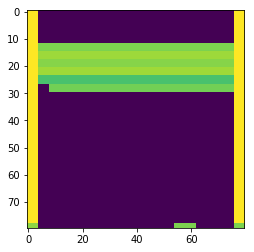

In [6]:
plt.imshow(preprocess(s2)[0])

In [7]:
from collections import deque
import random 

class ReplayMemory(object):
    def __init__(self, capacity):
        self.deque = deque(maxlen=capacity)
    
    def append(self, state, action, reward, next_state, done):
        self.deque.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.deque, batch_size)
    
    def __len__(self):
        return len(self.deque)

In [8]:
class FrameSkipper(object):
    # consecutive frame을 4개씩 병합하여 새로운 x를 하나씩 만드는 클래스
    # 만들어진 x는 4개씩 concat하고 s를 만들어서 DQN의 input으로 들어감
    def __init__(self, k_skip=4):
        self.state_deque = deque(maxlen=k_skip) # [x1, x2, x3, x4]
        self.frame_ls = []
        self.k_skip = k_skip
        
        # 최초에는 초기 화면(env.reset)으로 채워둠
        self.env = gym.make('BreakoutDeterministic-v4')
        padding_state = preprocess(self.env.reset())
        for _ in range(k_skip):
            self.state_deque.append(padding_state)
    
    def preprocess(self, img):
        # 저장할 때는 전처리를 거친 후 np.array 형태로 저장
        img = np.mean(img, axis=2).astype(np.uint8) # to gray, uint8 for low memory
        img = img[::2, ::2][17:97] # downsample(1/2) & to square
        img = np.expand_dims(img, 0) # (1, 80, 80)
        return img
    
    def aggregate_frame(self):
        # element-wise maximum to aggregate
        return np.maximum.reduce(self.frame_ls)
    
    def append_frame(self, s):
        self.frame_ls.append(self.preprocess(s))
        # 4개의 프레임을 skip한 후에는, 4개를 합쳐서(element-wise maximum) x를 만들고 저장
        if len(self) == self.k_skip:
            x = self.aggregate_frame()
            self.state_deque.append(x)
            self.frame_ls = []  # frame을 다시 처음부터 저장
            
    def get_state(self):
        S = np.array([self.state_deque[i] for i in range(self.k_skip)]) # S = [x1, x2, x3, x4], (4, 1, 80, 80)
        S = np.swapaxes(S, 0, 1) # (1, 4, 80, 80)
        return S
    
    def __len__(self):
        return len(self.frame_ls)

In [9]:
class DQN(nn.Module):
    def __init__(self, in_dim, n_action):
        super(DQN, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, (8, 8), stride=4), nn.ReLU(), # conv 1
            nn.Conv2d(32, 64, (4, 4), stride=2), nn.ReLU(), # conv 2
            nn.Conv2d(64, 64, (3, 3), stride=1), nn.ReLU() # conv 3
        )
        self.fc = nn.Sequential(
            nn.Linear(64*6*6, 512), nn.ReLU(), # hidden layer
            nn.Linear(512, n_action)
        )
        
    def to_tensor(self, img):
        img = torch.tensor(img, dtype=torch.float32, device=self.device).cuda(non_blocking=True) # to tensor
        img /= 255                                   # normalize into 0-1
        while img.dim() < 4 :                        # 4-dim
            img = img.unsqueeze(0)
        return img
        
    def forward(self, frames):
        frames = self.to_tensor(frames) 
        conved = self.conv(frames)
        conved = conved.view(conved.size(0), -1)
        output = self.fc(conved)
        return output

In [10]:
behavior_net = DQN(in_dim=4, n_action=4)
target_net = DQN(in_dim=4, n_action=4)

behavior_net.to(behavior_net.device) # model to cuda
target_net.to(target_net.device)     # model to cuda

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [11]:
def epsilon_decay(n_total_frame):
    return np.max([1 - 9.0*1e-07*n_total_frame, 0.1])    

In [12]:
def grow_batch_size(current_memory):
    # grow batch size from 32 to 128 as respect to memory size
    memory_ratio = current_memory / max_memory
    new_batch_size = int(32 + 96*memory_ratio)
    return new_batch_size

In [17]:
class Fitter():
    def __init__(self, env, behavior_net, target_net, train_method='DQN'):
        self.env = env
        self.train_method = train_method
        
        # networks
        self.behavior_net = behavior_net
        self.target_net = target_net
        self.behavior_net.to(self.behavior_net.device) # model to cuda
        self.target_net.to(self.target_net.device)     # model to cuda
        
        # train parameters
        self.gamma = 0.99 #as written in paper
        self.criterion = nn.SmoothL1Loss() # huber loss (error-clipping)
        self.optim = torch.optim.RMSprop(self.behavior_net.parameters(), lr=0.00025) #as written in paper
        
        # train details
        self.total_frame = 0
        self.total_episode = 0
        self.batch_size = 32
        self.memory_size = 1000000 # as written in paper
        self.min_replay = 50000 # as written in the paper
        self.replay_memory = ReplayMemory(self.memory_size)
        self.reward_ls = []
    
    def train(self, max_total_frame):
        while self.total_frame < max_total_frame :
            self.total_episode += 1
            
            frame_skipper = FrameSkipper(k_skip=4) #과거 k개의 frame을 하나의 state로 합쳐주는 클래스
            s = env.reset()  # small s represents each frame
            n_step = 0       # each episode의 step의 횟수 
        
            done = False
            while not done:
                self.total_frame += 1
                n_step += 1
                e = epsilon_decay(self.total_frame)

                # start of every 4 consecutive frames, choose action!                
                if n_step%4 == 1:
                    # S = [x1, x2, x3, x4] for neural-network input
                    # x represents feature(element-wise max) from every 4 consecutive frames(4*s)
                    S = frame_skipper.get_state()
                    self.S = S
                    r_sum = 0    # sum of reward for the following 4 frames
                    
                    # if it is the first frame of the game, Do Something!
                    if n_step == 1:
                        a = random.choice([1,2,3])
                    
                    # else, Choose an action by e-greedy
                    else:
                        if np.random.rand(1) < e :
                            a = env.action_space.sample()
                        else:
                            q_pred = self.behavior_net(S)
                            a = torch.argmax(q_pred).item()
                
                # repeat the same action 4 times
                s_next, r, done, _, = env.step(a)
                frame_skipper.append_frame(s_next)
                r_sum += r

                # end of every 4 consecutive frames
                # genenrate new x, and update S
                if n_step%4 == 0 :
                    S_new = frame_skipper.get_state()
                    self.replay_memory.append(S, a, r_sum, S_new, done)
                
                # no training when not enough replay
                if len(self.replay_memory) < self.min_replay:
                    continue
                else:
                    # train
                    batch_size = grow_batch_size(len(self.replay_memory))
                    mini_batch = replay_memory.sample(batch_size)
                    self.train_batch(mini_batch)                
                # single-episode(game) is now done
            
            
            # no updating target, no testing when not enough replay
            if len(self.replay_memory) < self.min_replay:
                continue

            # update target, do test for every 10 episodes(games)
            if self.total_episode%10 == 0:
                print('total_frame: %s'%self.total_frame)
                fitter.update_target()
                reward = fitter.test()
                self.reward_ls.append(reward)  
                
                
    def train_batch(self, mini_batch):
        batch_size = len(mini_batch)
        S = np.array([tup[0] for tup in mini_batch]).squeeze(1) # State
        A = np.array([tup[1] for tup in mini_batch]) # actions
        R = np.array([tup[2] for tup in mini_batch]) # rewards
        S_next = np.array([tup[3] for tup in mini_batch]).squeeze(1) # next_State
        D = np.array([tup[4] for tup in mini_batch]) # dones
        
        q_targets = self.target_net(S) # Q-values of current state with targetDDQN
        q_targets_next = self.target_net(S_next) # Q-values of next state from targetDDQN
        
        if self.train_method=='DQN':
            for i in range(batch_size):
                a, r, done = A[i], R[i], D[i]
                if done:
                    q_targets[i, a] = r
                else:
                    q_targets[i, a] = r + self.gamma*torch.max(q_targets_next[i])
        
        elif self.train_method=='DDQN':
            next_behavior_net_actions = torch.argmax(self.behaviorDDQN(S_next), dim=1) # choose argmax actions from behaviorDDQN in S_next
                    
            for i in range(batch_size):
                a, r, done = A[i], R[i], D[i]
                next_behavior_net_action = next_behavior_net_actions[i].item() # choose argmax actions from behaviorDDQN in S_next
                if done:
                    q_targets[i, a] = r
                else:
                    q_targets[i, a] = r + self.gamma*q_targets_next[i, next_behavior_net_action]
            
        # 예측치(pred)와 목표치(true)
        q_behaviors = self.behavior_net(S)
        
        self.optim.zero_grad()
        loss = self.criterion(q_targets, q_behaviors)
        loss.backward()
        self.optim.step()
        return

    
    def update_target(self):
        self.target_net.load_state_dict(self.behavior_net.state_dict())
        return 
    
    
    def test(self):
        frame_skipper = FrameSkipper()
        initial_state = self.env.reset()  # save initial state for comparison
        s = self.env.reset()
        n_step = 0
        r_sum = 0
        
        done=False
        while not done:
            # 초기 화면에서는 1,2,3 중 임의의 액션을 실행
            # 게임이 시작된 후, 공을 놓치면, life가 깍이고 다시 초기화면으로 돌아옴 
            if np.array_equal(s, initial_state):
                a = random.choice([1, 2, 3])
            else:
                S = frame_skipper.get_state()
                a = torch.argmax(self.behavior_net(S)).item()
            
            s, r, done, _ = self.env.step(a)
            frame_skipper.append(s)
            r_sum += r
            n_step += 1
            
        print('Total Step: %s \t Total Score: %s'%(n_step, r_sum))
        return r_sum

In [18]:
fitter = Fitter(env, behavior_net, target_net, train_method='DDQN')

In [19]:
# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')

In [ ]:
max_frame = 10000000
fitter.train(max_frame)

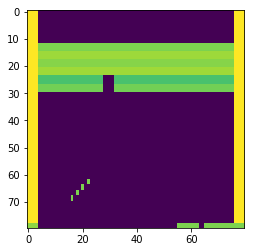

In [21]:
# how skip-frame works
plt.imshow(fitter.S[0][0])